In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import xarray as xr
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
from keras.models import load_model
from keras.utils import plot_model
from deepsky.gan import gan_loss
from IPython.display import Image
from netCDF4 import Dataset
import h5py


Using TensorFlow backend.


In [10]:
gan_history_files = sorted(glob("/scratch/dgagne/storm_gan_20170614/gan_loss_history_*.csv"))
gan_history_coll = []
for gan_history_file in gan_history_files:
    print(gan_history_file)
    gan_history_coll.append(pd.read_csv(gan_history_file, index_col="Time", parse_dates=["Time"]))

/scratch/dgagne/storm_gan_20170614/gan_loss_history_000.csv
/scratch/dgagne/storm_gan_20170614/gan_loss_history_001.csv
/scratch/dgagne/storm_gan_20170614/gan_loss_history_002.csv
/scratch/dgagne/storm_gan_20170614/gan_loss_history_003.csv
/scratch/dgagne/storm_gan_20170614/gan_loss_history_004.csv
/scratch/dgagne/storm_gan_20170614/gan_loss_history_005.csv


In [3]:
epoch_vals = np.where(gan_history_coll[g]["Batch"].values == 0)[0]
gan_history_coll[g].columns

NameError: name 'g' is not defined

[   0  892 1784 2676 3568 4460 5352 6244 7136 8028]
[   0  892 1784 2676 3568 4460 5352 6244 7136 8028]
[   0  892 1784 2676 3568 4460 5352 6244 7136 8028]
[   0  892 1784 2676]
[   0  892 1784 2676]
[   0  892 1784 2676]


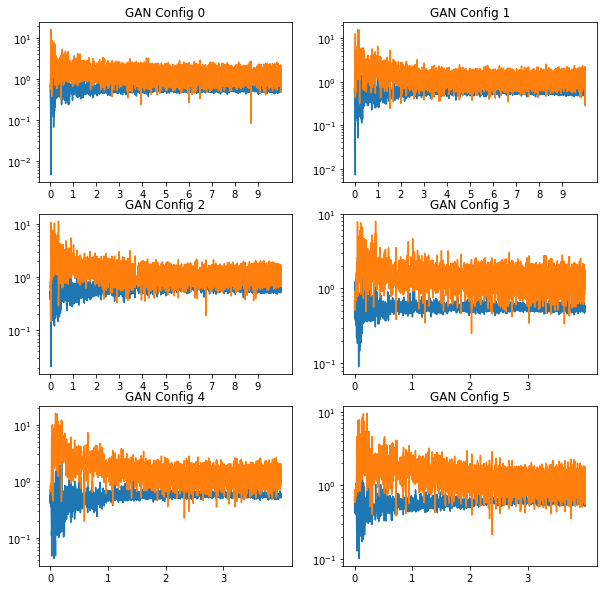

In [11]:
fig, axes = plt.subplots(3,2, figsize=(10, 10))
axef = axes.ravel()
for g in range(len(gan_history_coll)):
    axef[g].plot(np.arange(gan_history_coll[g].shape[0]), gan_history_coll[g]["Disc Loss"])
    axef[g].plot(np.arange(gan_history_coll[g].shape[0]), gan_history_coll[g]["Gen Loss"])
    epoch_vals = np.where(gan_history_coll[g]["Batch"].values == 0)[0]
    print(epoch_vals)
    axef[g].set_xticks(epoch_vals)
    axef[g].set_xticklabels(gan_history_coll[g].iloc[epoch_vals]["Epoch"].values.astype(int) - 1)
    axef[g].set_yscale("log")
    axef[g].set(title="GAN Config {0:d}".format(g))

[   0  892 1784 2676 3568 4460 5352 6244 7136 8028]
[   0  892 1784 2676 3568 4460 5352 6244 7136 8028]
[   0  892 1784 2676 3568 4460 5352 6244 7136 8028]
[   0  892 1784 2676]
[   0  892 1784 2676]
[   0  892 1784 2676]


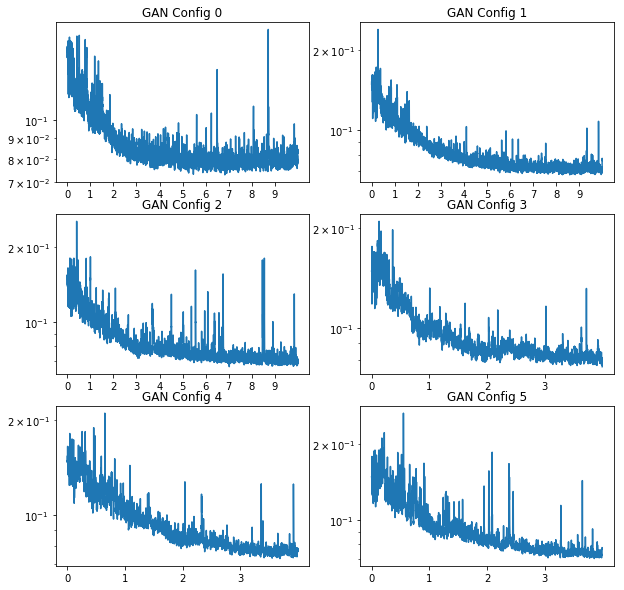

In [12]:
fig, axes = plt.subplots(3,2, figsize=(10, 10))
axef = axes.ravel()
for g in range(len(gan_history_coll)):
    axef[g].plot(np.arange(gan_history_coll[g].shape[0]), gan_history_coll[g]["Gen_Enc Loss"])
    epoch_vals = np.where(gan_history_coll[g]["Batch"].values == 0)[0]
    print(epoch_vals)
    axef[g].set_xticks(epoch_vals)
    axef[g].set_xticklabels(gan_history_coll[g].iloc[epoch_vals]["Epoch"].values.astype(int) - 1)
    axef[g].set_yscale("log")
    axef[g].set(title="GAN Config {0:d}".format(g))

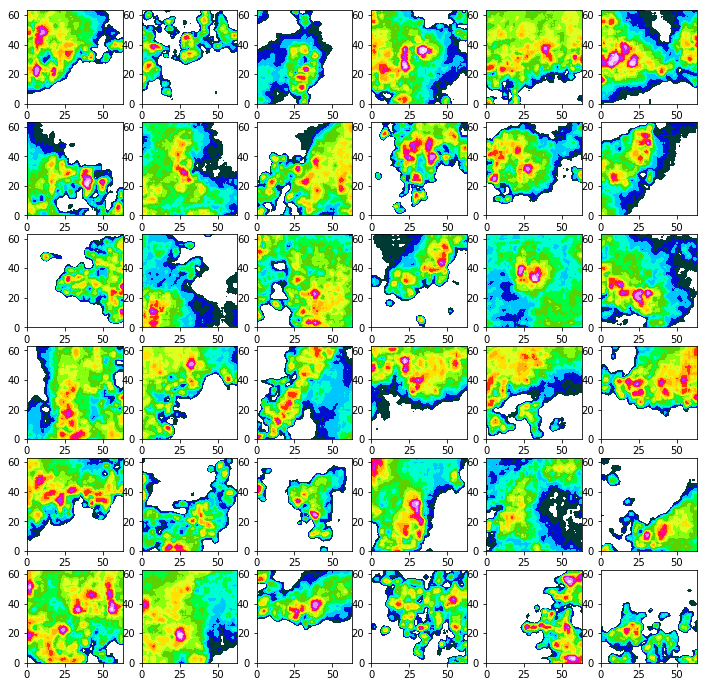

In [17]:
ds = xr.open_dataset("/scratch/dgagne/storm_gan_20170614/gan_gen_patches_005_epoch_004.nc")
fig, axes = plt.subplots(6,6, figsize=(12, 12))
axef = axes.ravel()
for a, ax in enumerate(axef):
    ax.contourf(ds["gen_patch"][a, :, :, 0], np.arange(0, 80, 5), cmap="gist_ncar")
ds.close()

In [9]:
gan_param_configs = pd.read_csv("/scratch/dgagne/storm_gan_20170519/gan_param_combos.csv")
gan_param_configs

,Index,learning_rate,generator_input_size,min_data_width,min_conv_filters,beta_one,filter_width,batch_size,leaky_relu_alpha
0,0,0.0001,16,4,64,0.2,5,256,0.02
1,1,0.0001,16,4,128,0.2,5,256,0.02
2,2,0.0001,32,4,64,0.2,5,256,0.02
3,3,0.0001,32,4,128,0.2,5,256,0.02
4,4,0.0001,128,4,64,0.2,5,256,0.02
5,5,0.0001,128,4,128,0.2,5,256,0.02


In [20]:

enc= load_model("/scratch/dgagne/storm_gan_20170614/gan_encoder_000001_epoch_0010.h5", custom_objects={"gan_loss":gan_loss})
gen = load_model("/scratch/dgagne/storm_gan_20170614/gan_generator_000001_epoch_0010.h5")

In [42]:
out = enc.predict(gen.predict(-1 * np.ones((1, 32))))
print(out)

[[-0.32335043 -0.59500027  0.00592168 -0.80879426 -0.17371298 -0.76486641
  -0.37233087 -0.46444541 -0.47976729 -0.38488057 -0.44614512 -0.64898086
   0.20797372 -0.22843304 -0.46296555 -0.62475139  0.04855406 -0.60358727
  -0.38705644 -0.10686914 -0.70023733 -0.61624885 -0.79733193 -0.33116904
  -0.7893647  -0.70657444 -0.58646798 -0.70238    -0.35003623 -0.74947917
  -0.34132004 -0.84839135]]


In [24]:
plot_model(disc, to_file="/scratch/dgagne/storm_gan_20170517/gan_discriminator_000.png", show_shapes=True)

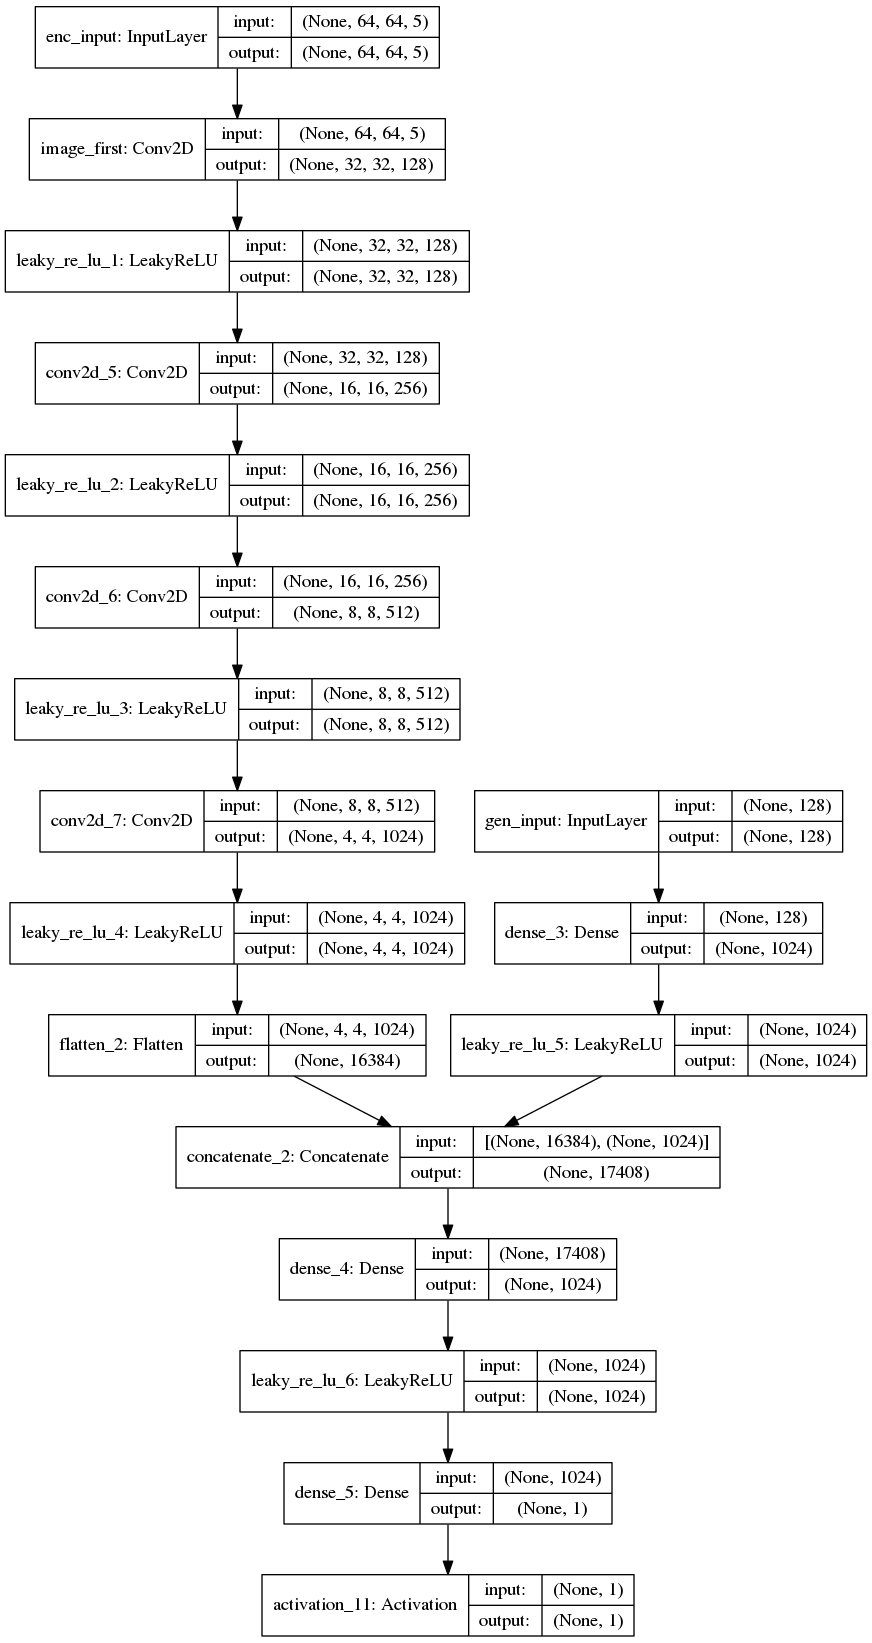

In [25]:
Image("/scratch/dgagne/storm_gan_20170517/gan_discriminator_000.png")

In [32]:
d = h5py.File("/scratch/dgagne/storm_gan_20170519/gan_encoder_000001_epoch_0010.h5")

In [44]:
dir(d)

['_MutableMapping__marker',
 '__abstractmethods__',
 '__bool__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_d',
 '_e',
 '_id',
 '_lapl',
 '_lcpl',
 'attrs',
 'clear',
 'close',
 'copy',
 'create_dataset',
 'create_group',
 'driver',
 'fid',
 'file',
 'filename',
 'flush',
 'get',
 'id',
 'items',
 'keys',
 'libver',
 'mode',
 'move',
 'name',
 'parent',
 'pop',
 'popitem',
 'ref',
 'regionref',
 'require_dataset',
 'require_group',
 'setdefault',
 'upd

In [46]:
for key in d.keys():
    print(key)

model_weights
optimizer_weights


In [66]:
list(d["model_weights"].keys())

['activation_10',
 'activation_6',
 'activation_7',
 'activation_8',
 'activation_9',
 'conv2d_1',
 'conv2d_2',
 'conv2d_3',
 'conv2d_4',
 'dense_2',
 'enc_input',
 'flatten_1']

In [77]:
list(d["model_weights"]["conv2d_1"]["conv2d_1"].keys())

['bias:0', 'kernel:0']